# Generative Adversarial Networks

## What are GANs?
* Type of neural network that uses two networks competing against each other to generate data
* Described as a counterfeiter versus a detective

## How do GANs work?
Let's split this into two main characters:
1. Generator (Counterfeiter)
  * Receives random noise (Gaussian Destribution)
  * Outputs data (often images)
2. Discriminator (Detective)
  * Takes a data set consisting of real images from the real data set and fake images from the generator
  * It attempts to classify real vs fake images (always binary classification)

And as time goes on the generator will try to improve its images trying to fool the discriminator until it generates images that appear to mimic the real data set and the discriminator can eventually no longer tell the difference between those two.

First attempt: 

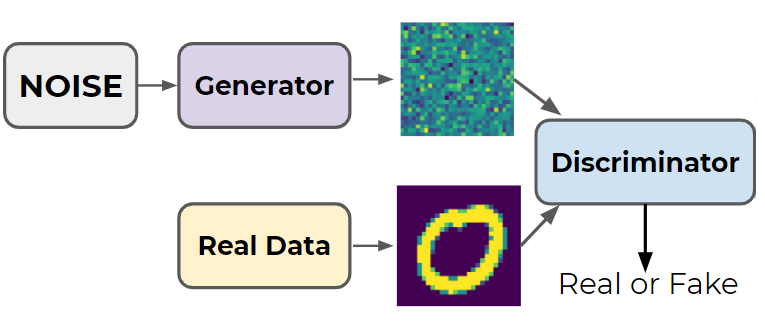

Fourth and final attempt:

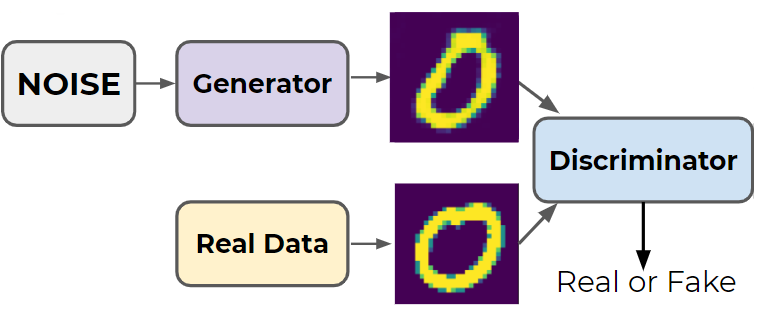


## What are the training phases for GANs?
1. Train Discriminator
  * Real images are grouped together with fake images from the generator
  * Discriminator trains to distinguish real from fake (with backpropagation)
2. Train Generator
  * Produce fake images with generator
  * Label fake images as real images
  * Attempt to produce images the discriminator believes to be real

Keep in mind the following things:
* The generator never gets to see real images
* The generator produces images only based off gradients flowing back through the discriminator


## What are the difficulties with GANs?
1. Training Resources
  * Training GANs with with CPUs will be challenging, we recommend to use Google Colab's GPU for reasonable training time
2. Mode Collapse
  * The generator will figure out it can fool the discriminator, and eventually 'collapses' to only produce those images
  * As best practices we need to provide multiple faces
  * Deep Convolutional GANs or mini-batch discrimination can help avoiding mode collapse
3. Instability
  * Difficult to tell how well a model is performing at generating images
  * It is recommended to use layers, neurons, activation functions, learning rates, etc... when dealing with complex images

# The Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


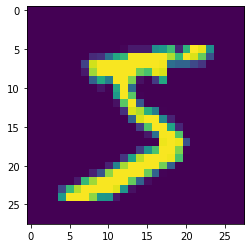

In [6]:
plt.imshow(X_train[0])

In [7]:
only_zeros = X_train[y_train==0]

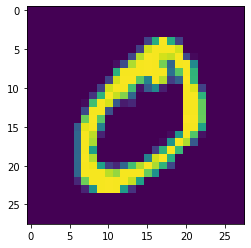

In [8]:
plt.imshow(only_zeros[0])

# The Model - Creation of the Generator and Discriminator

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.models import Sequential

In [17]:
discriminator = Sequential()
# We need to first flatten the 2d images
discriminator.add(Flatten(input_shape=[28, 28]))
discriminator.add(Dense(150, activation='relu'))
discriminator.add(Dense(100, activation='relu'))
# Final output layer
discriminator.add(Dense(1, activation='sigmoid'))
# For the loss we are only going to see if it is fake or true
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

In [18]:
codings_size = 100
# Before creating the generator we need to define the coding size i.e. the latent representation
# Similar to autoencoders, 784 -> 150 -> 100 -> 150 -> 784, we must expand back out to generate an output to full the discriminator
generator = Sequential()
generator.add(Dense(100, activation='relu', input_shape=[codings_size]))
generator.add(Dense(150, activation='relu'))
generator.add(Dense(784, activation='relu'))
# Finally we need to reshape the data into the original size, 28X28
generator.add(Reshape([28, 28]))

In [19]:
# We don't have to compile the generator
GAN = Sequential([generator, discriminator])

In [20]:
discriminator.trainable = False

In [21]:
GAN.compile(loss='binary_crossentropy', optimizer='adam')

# Model Training

In [22]:
batch_size = 32

In [23]:
my_data = only_zeros

In [24]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [25]:
my_data.shape

(5923, 28, 28)

In [26]:
5923/32

185.09375

In [27]:
# What the drop remainder is doing is, it's dropping the decimals in 185.09375
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [28]:
epochs = 1

In [31]:
generator, discriminator = GAN.layers

for epoch in range(epochs):
  print(f'Currently on Epoch: {epoch+1}')
  i = 0

  for X_batch in dataset:
    i = i+1
    if i%100 == 0:
      print(f'\t Currently on batch number {i} of {len(my_data)//batch_size}')

    # Train Discriminator 
    noise = tf.random.normal(shape=[batch_size, codings_size])
    gen_images = generator(noise)
    X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch, tf.float32)], axis=0)
    y1 = tf.constant([[0.0]]*batch_size + [[1.0]]*batch_size  )
    discriminator.trainable = True
    discriminator.train_on_batch(X_fake_vs_real, y1)

    # Train Generator
    noise = tf.random.normal(shape=[batch_size, codings_size])
    y2 = tf.constant([[1.0]]*batch_size)
    discriminator.trainable = False
    GAN.train_on_batch(noise, y2)

Currently on Epoch: 1
	 Currently on batch number 100 of 185


In [32]:
noise = tf.random.normal(shape=[10, codings_size])

In [33]:
noise.shape

TensorShape([10, 100])

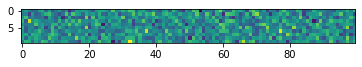

In [34]:
plt.imshow(noise)

In [35]:
images = generator(noise)

In [36]:
images.shape

TensorShape([10, 28, 28])

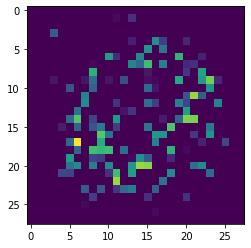

In [37]:
plt.imshow(images[0])

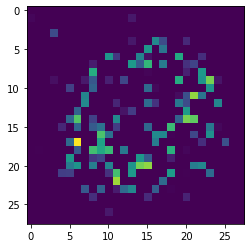

In [38]:
plt.imshow(images[1])